# DTSA5510 Week 4 Project Part 1
Nathan Hansen

### Introduction

The goal of this project is to train unsupervised and supervised models to predict news article topics. 

The [BBC News Classification dataset](https://www.kaggle.com/competitions/learn-ai-bbc/overview) used in the analysis was retrieved from Kaggle, and contains 2225 articles in the categories of business, entertainment, politics, sports, and technology. 



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os

import kaggle

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.utils.random import sample_without_replacement

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score
)

from functions import train_NMF, GridSearch, pred_to_csv, plot_occ, plot_performance, generate_PCA, NMF_GridSearch, train_LR, NMF_instance

# Draw grid in background
plt.rcParams['axes.axisbelow'] = True

SCRIPT_DIR = os.getcwd()
RANDOM_SEED = 1

### EDA and Data Cleaning
Some initial data exploration:

In [2]:
train = pd.read_csv(os.path.join(SCRIPT_DIR, 'BBC News Train.csv'))
test = pd.read_csv(os.path.join(SCRIPT_DIR, 'BBC News Test.csv'))

print(train.head())
print(train.shape)
print(test.head())
print(test.shape)

   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business
(1490, 3)
   ArticleId                                               Text
0       1018  qpr keeper day heads for preston queens park r...
1       1319  software watching while you work software that...
2       1138  d arcy injury adds to ireland woe gordon d arc...
3        459  india s reliance family feud heats up the ongo...
4       1020  boro suffer morrison injury blow middlesbrough...
(735, 2)


We can see that the training data is composed of 1490 articles described by three columns: the article ID, the text of the article (with formatting and punctuation removed), and the category it belongs to.

The test data has 735 articles in the same format, but without the categories (which must be predicted).

##### Duplicate Entries

There are 50 duplicate entries in the training data. The categories match between duplicates in the training data, which means we can simply remove the duplicates. If the categories didn't match it would require more careful consideration about which to keep, or that both instances are removed.

The testing data will be left as-is, regardless of duplicates, which is required for accuracy evaluation through kaggle.

In [3]:
# Check for duplicates
dupes_train = train['Text'].duplicated(keep=False)
print("Duplicate Entries:", np.sum(dupes_train)//2)
print(train[dupes_train].sort_values('Text').head(6))

# Remove duplicates
train.drop_duplicates(subset=['Text'], inplace=True, ignore_index=True)
print("\nDuplicate Entries:", np.sum(train['Text'].duplicated(keep=False))//2)

Duplicate Entries: 50
      ArticleId                                               Text  \
494        1326  ask jeeves joins web log market ask jeeves has...   
228        1098  ask jeeves joins web log market ask jeeves has...   
1430       1042  aviator  creator  in oscars snub the man who s...   
695         374  aviator  creator  in oscars snub the man who s...   
443        1847  blind student  hears in colour  a blind studen...   
1317        145  blind student  hears in colour  a blind studen...   

           Category  
494            tech  
228            tech  
1430  entertainment  
695   entertainment  
443            tech  
1317           tech  

Duplicate Entries: 0


##### Data Distribution across Categories

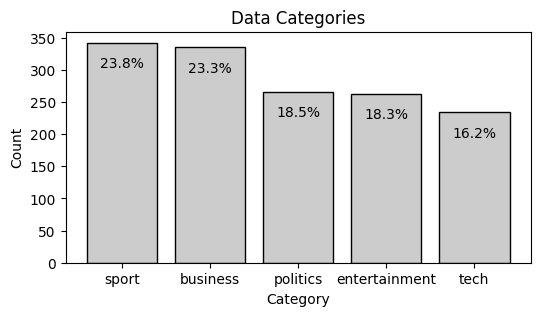

In [4]:
cats = train['Category'].value_counts()
pcts = [f"{p:.1%}" for p in cats.values/np.sum(cats.values)]
B = plt.bar(cats.index.values, cats.values, color='0.8', edgecolor='k')
plt.bar_label(B, labels=pcts, label_type='edge', padding=-20)
plt.title('Data Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.gcf().set_size_inches(6, 3)
plt.show()

We can see that there is an uneven split across categories for the articles. Fortunately, the distribution isn't heavily imbalanced towards any one category, so the risk of over-fitting to a subset of categories is low.

##### Word Occurrences

In [5]:
cvec = CountVectorizer().fit(train["Text"])
cnames = cvec.get_feature_names_out()
counts = cvec.transform(train['Text'])
words_df = pd.DataFrame(cnames, columns=['Word'])
words_df['Occ'] = np.sum(counts.toarray(), 0)
words_df['DocOcc'] = np.sum(counts.toarray()>0, 0)

words_df.sort_values('Occ', ascending=False, inplace=True, ignore_index=True)
print(words_df.head(20))
print(words_df.shape)

    Word    Occ  DocOcc
0    the  33933    1440
1     to  16062    1435
2     of  12582    1430
3    and  11948    1425
4     in  11424    1428
5    for   5623    1335
6     is   5337    1239
7   that   5073    1194
8     it   5025    1246
9     on   4932    1297
10  said   4695    1226
11   was   3904    1157
12    he   3747     910
13    be   3667    1113
14  with   3380    1202
15   has   3154    1185
16    as   3128    1074
17  have   3043    1076
18    at   2968    1135
19    by   2898    1113
(24746, 3)


The most common words are very generic (not related to any one subject) and appear in most documents, which is expected. 

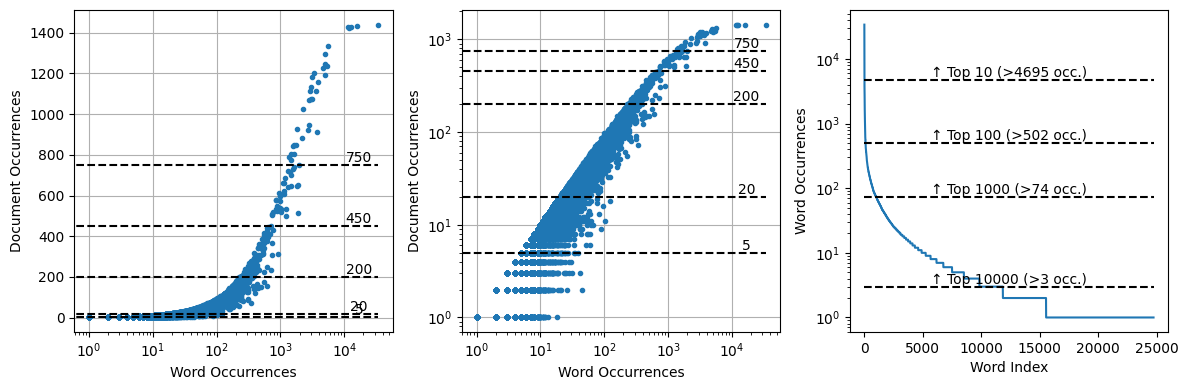

In [6]:
plot_occ(words_df)

Looking at the plots of word occurrences versus the number of documents those words appear in we can see an elbow at around 250 word occurrences after which their document occurrence rate increases rapidly. As noted earlier, the words that appear frequently and in most documents are very generic, which means they are unlikely to provide useful information when distinguishing between categories. Additionally, the low-end of document occurrences may be too infrequent for useful trends to be extracted. From the plots we can see that only approx. 40% (10000 of 24746) of the data has more than three document occurrences, suggesting that a large portion of the words could be removed. Removing words from the datasets is useful for reducing training time, and may improve model accuracy by removing "noise".

To evaluate this idea the data will be vectorized on several different document occurrence thresholds (5, 20, 200, 450, 750), with different combinations of lower and upper boundaries.

##### Text Encoding
Currently, the text of each article is represented as a list of words, which will need to be converted to a numeric representation for the calculations in our analysis. The sklearn implementation of the "Term Frequency, Inverse Document Frequency" (TF-IDF) method will be used, which will assign a weight to each word based on the frequency with which it appears in a given article, divided by the frequency with which it appears in all articles. This will highlight the words that are most unique and frequently used in a given article, which can be used later when predicting its category. Since each article only contains a fraction of all used words the TF-IDF encoding produces sparse vectors.

Additional datasets will be prepared including N-grams of up to length one and length two. This will be used to evaluate whether the additional context provided by a longer sequence of words is useful for category prediction (e.g. "pipeline" vs "data pipeline" vs "oil pipeline", etc.).

In [7]:
# Convert text to a numeric bag-of-words format using the "Term Frequency, Inverse Document Frequency" method
# Prepare parameter combinations
doc_lowers = [1, 1, 5, 20, 1, 1, 1, 5, 5]
doc_count = train.shape[0]
doc_uppers = [doc_count, doc_count, doc_count, doc_count, 200, 450, 750, 200, 200]
ngrams = [1, 2, 1, 1, 1, 1, 1, 1, 2]
dataset_df = pd.DataFrame({'DocLower': doc_lowers, 'DocUpper': doc_uppers, 'Ngrams': ngrams})

# Apply TF-IDF with each parameter combination
train_feature_sets = []
test_feature_sets = []
fname_sets = []
for i in range(len(doc_lowers)):
    tmp = TfidfVectorizer(sublinear_tf=True, min_df=doc_lowers[i], max_df=doc_uppers[i], ngram_range=(1, ngrams[i]), stop_words='english').fit(train['Text'])
    train_tfm = tmp.transform(train['Text']).toarray()
    test_tfm = tmp.transform(test['Text']).toarray()
    train_feature_sets.append(train_tfm)
    test_feature_sets.append(test_tfm)
    fname_sets.append(tmp.get_feature_names_out())
dataset_df['Train'] = train_feature_sets
dataset_df['Features'] = [s.shape[1] for s in train_feature_sets]
dataset_df['Test'] = test_feature_sets
dataset_df['Names'] = fname_sets

# Print summary
dataset_df.drop(columns=['Train', 'Test', 'Names'], inplace=False)

,DocLower,DocUpper,Ngrams,Features
0,1,1440,1,24456
1,1,1440,2,250233
2,5,1440,1,6944
3,20,1440,1,2237
4,1,200,1,24388
5,1,450,1,24450
6,1,750,1,24454
7,5,200,1,6876
8,5,200,2,9409


The resulting number of features varies as expected, with narrower document limits reducing the length of the encoded sparse vectors. Additionally, including longer N-grams can greatly increase the number of features (10x increase from row 0 to row 1, 36% increase from row 7 to row 8).

##### Top/Bottom Words per Category
We can perform a sanity check by using a $\chi^2$ test to find the words that are the most and least correlated with each category:

In [8]:
cats = train['Category'].unique()
df = pd.DataFrame(dataset_df['Train'][0], columns=dataset_df['Names'][0])
df['cats'] = train['Category']
groupsums = df.groupby(['cats']).sum()
ex = groupsums.sum(0)/5
chi = ((groupsums-ex)**2)/ex
N = 5
for c in cats:
    print(f"{c} (most): {chi.T.nlargest(N, c).index.tolist()}")
    print(f"{c} (least): {chi.T.nsmallest(N, c).index.tolist()}")
    print()

business (most): ['shares', 'bank', 'growth', 'oil', 'economy']
business (least): ['territories', 'frederic', 'drum', 'question', 'warnings']

tech (most): ['users', 'software', 'microsoft', 'technology', 'computer']
tech (least): ['dug', 'crew', 'stunning', 'restored', 'location']

politics (most): ['labour', 'election', 'blair', 'party', 'tories']
politics (least): ['optimism', 'exploring', 'gangs', 'finances', 'colleague']

sport (most): ['cup', 'coach', 'match', 'injury', 'season']
sport (least): ['displaying', 'official', 'availability', 'cynical', 'verge']

entertainment (most): ['film', 'actor', 'awards', 'album', 'oscar']
entertainment (least): ['proceedings', 'flair', 'journal', 'size', 'carnival']



Intuitively, the most correlated words make sense for their category, though it can be hard to predict the least correlated words.

### Training NMF Models

For each dataset Non-Negative Matrix Factorization (NMF) will be used to predict the category of each article, then training accuracy calculated. Since the mapping between original categories and their predicted numeric representation is not fixed ('tech', 'business', etc. could be assigned in any order from 0 to 4) the mapping is inferred by calculating the mean predicted value across all known samples of a given category, then sorting category-mean pairs and assigning their indecies as the predicted values.

To find an effective parameter combination, a brief cross-validated grid search is applied to two datasets:

In [9]:
data = pd.DataFrame(dataset_df['Train'][3])
data['cats'] = train['Category']
gridNMF = NMF_GridSearch(data, 5, {'solver': ['cd', 'mu'], 'beta_loss': ['frobenius', 'kullback-leibler']}, random_seed=RANDOM_SEED)
gridNMF.fit(use_mode=False);


Evaluating Parameter Set 1 of 4: {'solver': 'cd', 'beta_loss': 'frobenius'}
Train: 0.940, Test: 0.939, Time: 0.794 sec
Evaluating Parameter Set 2 of 4: {'solver': 'cd', 'beta_loss': 'kullback-leibler'}
Skipping: parameter combination not allowed
Evaluating Parameter Set 3 of 4: {'solver': 'mu', 'beta_loss': 'frobenius'}
Train: 0.945, Test: 0.945, Time: 1.766 sec
Evaluating Parameter Set 4 of 4: {'solver': 'mu', 'beta_loss': 'kullback-leibler'}
Train: 0.944, Test: 0.947, Time: 18.532 sec


In [10]:
data = pd.DataFrame(dataset_df['Train'][8])
data['cats'] = train['Category']
gridNMF = NMF_GridSearch(data, 5, {'solver': ['cd', 'mu'], 'beta_loss': ['frobenius', 'kullback-leibler']}, random_seed=RANDOM_SEED)
gridNMF.fit(use_mode=False);

Evaluating Parameter Set 1 of 4: {'solver': 'cd', 'beta_loss': 'frobenius'}
Train: 0.951, Test: 0.948, Time: 3.340 sec
Evaluating Parameter Set 2 of 4: {'solver': 'cd', 'beta_loss': 'kullback-leibler'}
Skipping: parameter combination not allowed
Evaluating Parameter Set 3 of 4: {'solver': 'mu', 'beta_loss': 'frobenius'}
Train: 0.957, Test: 0.955, Time: 6.632 sec
Evaluating Parameter Set 4 of 4: {'solver': 'mu', 'beta_loss': 'kullback-leibler'}
Train: 0.941, Test: 0.944, Time: 88.703 sec


From these results the 'mu' solver and frobenius loss were chosen as a good tradeoff between higher accuracy and longer training time.

In [11]:
# Fit NMF on all datasets
train_NMF(dataset_df, train['Category'], {'solver':'mu', 'beta_loss':'frobenius'}, RANDOM_SEED, True)

Training 1 of 9
Training 2 of 9
Training 3 of 9
Training 4 of 9
Training 5 of 9
Training 6 of 9
Training 7 of 9
Training 8 of 9
Training 9 of 9


##### Evaluating NMF Models
The trained models can then be evaluated on the test data by uploading their predictions to kaggle for accuracy checking:

In [12]:
# Export predictions for checking via Kaggle
# for i in range(len(dataset_df)):
#     pred = np.argmax(dataset_df['Model_NMF'][i].transform(dataset_df['Test'][i]), 1)
#     fpath = pred_to_csv(pred, test['ArticleId'], os.path.join(SCRIPT_DIR, 'Datasets'), dataset_df['ICM_NMF'][i], name=f'submission_{i}')
#     # Submit generated csv file
#     kaggle.api.competition_submit(fpath, f"A_{i}", "learn-ai-bbc")

In [13]:
# Manually retrieved from competition submissions page
dataset_df['TestAcc'] = [0.95102, 0.93061, 0.93741, 0.93469, 0.94965, 0.93605, 0.94829, 0.95102, 0.96326]

In [14]:
dataset_df.drop(columns=['Train', 'Test', 'Names', 'ICM_NMF', 'Model_NMF'], inplace=False)

,DocLower,DocUpper,Ngrams,Features,TrainAcc,Time_NMF,TestAcc
0,1,1440,1,24456,0.940972,3.754273,0.95102
1,1,1440,2,250233,0.938194,34.166445,0.93061
2,5,1440,1,6944,0.952083,1.003000,0.93741
3,20,1440,1,2237,0.944444,0.255275,0.93469
4,1,200,1,24388,0.955556,3.157532,0.94965
5,1,450,1,24450,0.952778,3.755075,0.93605
6,1,750,1,24454,0.945139,3.811051,0.94829
7,5,200,1,6876,0.954861,1.013465,0.95102
8,5,200,2,9409,0.954861,1.373749,0.96326


All resulting testing accuracies are at least 93%. The dataset with no words removed and including N-grams of up to two words (2-grams) had the lowest accuracy (93%). The highest accuracy (96.3%) was achieved by limiting document frequency to at least 5 occurrences and at most 200 occurrences, supporting the idea that including too frequently or infrequently used words may interfere with fitting the model. Adding 2-grams to a dataset resulted in lower performance in model #1 (vs #0), but higher performance in #8 (vs #7), demonstrating that the added context from longer sequences of words can be useful in predictions, but they similarly require trimming to remove the less-useful sequences.

In [15]:
cats = list(dataset_df['ICM_NMF'][0].values())
for i, weights in enumerate(dataset_df['Model_NMF'][0].components_):
    indexes = np.flip((-weights).argsort()[:N])
    print(cats[i], dataset_df['Names'][0][indexes])

tech ['technology' 'mobile' 'said' 'users' 'people']
sport ['team' 'cup' 'win' 'england' 'game']
politics ['party' 'blair' 'election' 'mr' 'labour']
entertainment ['actor' 'award' 'awards' 'best' 'film']
business ['market' 'year' 'economic' 'economy' 'growth']


Again, as a sanity check the most strongly weighted words per category can be retrieved. We can see that the chosen words make intuitive sense.

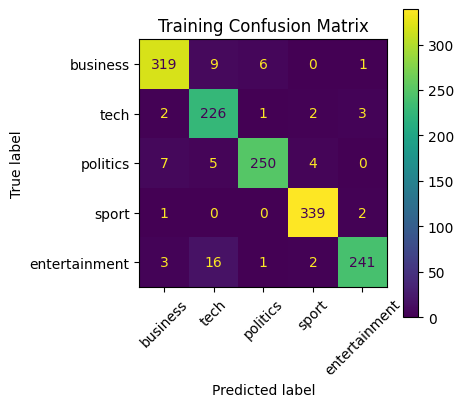

In [16]:
N = 7
model = dataset_df['Model_NMF'][N]
pred = np.argmax(model.transform(dataset_df['Train'][N]), 1)
pred = [dataset_df['ICM_NMF'][N][p] for p in pred]
labels = train['Category'].unique()
conf_mat = confusion_matrix(train['Category'], pred, labels=labels)
cm_plot = ConfusionMatrixDisplay(conf_mat, display_labels=labels)
cm_plot.plot()
plt.gcf().set_size_inches(4, 4)
plt.title("Training Confusion Matrix")
ax = plt.gca()
T = ax.get_xticks()
TL = ax.get_xticklabels()
ax.set_xticks(T, TL, rotation=45)
plt.show()

The confusion matrix shows what we would expect from a model (#7) with high accuracy, with most entries being correctly classified. The most commonly confused categories were tech with entertainment, and business with politics, which understandably may have overlap in their word usage.

### Varying Data Size
Model performance can be compared as the quantity of training data is varied. In this case, accuracy will be evaluated on the baseline dataset (#0) at 10%, 20%, and 50% of the training data, with articles selected randomly.

In [17]:
# Generate data fractions for training
fracs = [0.1, 0.2, 0.5]
N = len(dataset_df['Train'][0])
samples = []
for f in fracs:
    # Get indexes of samples
    samples.append(sample_without_replacement(N, int(N*f), random_state=RANDOM_SEED))

vary_data = [dataset_df['Train'][0][idx] for idx in samples]
vary_cats = [train['Category'][idx] for idx in samples]

# Train a model on each fraction of training data
train_accs = []
preds = []
icms = []
for i in range(len(fracs)):
    model = NMF_instance(5, {'solver':'mu', 'beta_loss':'frobenius'}, random_state=RANDOM_SEED)
    train_acc, _ = model.fit_eval(vary_data[i], vary_cats[i], False)
    train_accs.append(train_acc)
    preds.append(model.predict(dataset_df['Test'][0]))
    icms.append(model.get_invcatmap())

vary_df = pd.DataFrame(fracs, columns=["Fraction"])
vary_df['TrainAcc'] = train_accs

In [18]:
# Export predictions for checking via Kaggle
# for i in range(len(vary_df)):
#     fpath = pred_to_csv(preds[i], test['ArticleId'], os.path.join(SCRIPT_DIR, 'Datasets'), icms[i], name=f'submission_{i}')
#     # Submit generated csv file
#     kaggle.api.competition_submit(fpath, f"sv_{i}", "learn-ai-bbc")

In [19]:
# Manually retrieved from competition submissions page
vary_df['TestAcc'] = [0.87482, 0.95102, 0.94149]
pd.concat([vary_df, pd.DataFrame([[1, dataset_df['TrainAcc'][0], dataset_df['TestAcc'][0]]], columns=vary_df.columns)], ignore_index=True).round(3)

,Fraction,TrainAcc,TestAcc
0,0.1,0.861,0.875
1,0.2,0.969,0.951
2,0.5,0.946,0.941
3,1.0,0.941,0.951


From the table we can see that the model achieved its maximum accuracy with as little as 20% of the training data.

##### Supervised Model Training
While the accuracy of the (unsupervised) NMF method was reasonable, it might be further improved by using a supervised model. In this case, LogisticRegression (LR) was chosen, which will be trained on both baseline and PCA-transformed datasets. A five-fold cross-validated grid search method will be used to find optimal parameters for each dataset.

##### Principle Component Analysis (PCA)
Similarly to NMF, PCA can be used reduce the number of features in the dataset and will be used here as a pre-processor for the supervised models. At the expense of additional data preparation time the training time is expected to decrease while accuracy might increase by deemphasising less important features (similar to trimming the sparse word vectors).

In [20]:
# This cell can take ~5 min to run
generate_PCA(dataset_df, train['Category'])

0: (1440, 24456) -> (1440, 1219)
1: (1440, 250233) -> (1440, 1297)
2: (1440, 6944) -> (1440, 1151)
3: (1440, 2237) -> (1440, 952)
4: (1440, 24388) -> (1440, 1221)
5: (1440, 24450) -> (1440, 1219)
6: (1440, 24454) -> (1440, 1219)
7: (1440, 6876) -> (1440, 1152)
8: (1440, 9409) -> (1440, 1173)


As expected, the use of PCA results in greatly reduced dimensions for each dataset, though it is a time-consuming process. Grid search will be applied to two of the datasets to estimate an optimal parameter combination, which will be applied when training all datasets.

In [21]:
N = 3
param_gridLR = {
    "C": 10.0 ** np.arange(-5, 5),
    "solver": ['lbfgs', 'newton-cg'],
}
print(f'Evaluating: Baseline {N}')
tmp = pd.DataFrame(dataset_df['Train'][i])
tmp['cats'] = train['Category']
# Perform grid search to determine optimal parameters
gridLR = GridSearch(tmp, param_gridLR, LogisticRegression(random_state=RANDOM_SEED), cv=5, random_seed=RANDOM_SEED)
gridLR.fit();

Evaluating: Baseline 3
Evaluating Parameter Set: 1/20 (5.0%)
Train: 0.241, Test: 0.215, Time: 1.093 sec
Train: 0.241, Test: 0.215, Time: 0.959 sec
Evaluating Parameter Set: 3/20 (15.0%)
Train: 0.241, Test: 0.215, Time: 0.981 sec
Train: 0.241, Test: 0.215, Time: 0.991 sec
Evaluating Parameter Set: 5/20 (25.0%)
Train: 0.288, Test: 0.266, Time: 0.828 sec
Train: 0.288, Test: 0.267, Time: 0.934 sec
Evaluating Parameter Set: 7/20 (35.0%)
Train: 0.435, Test: 0.414, Time: 0.754 sec
Train: 0.435, Test: 0.415, Time: 1.162 sec
Evaluating Parameter Set: 9/20 (45.0%)
Train: 0.946, Test: 0.901, Time: 1.003 sec
Train: 0.946, Test: 0.901, Time: 1.159 sec
Evaluating Parameter Set: 11/20 (55.0%)
Train: 0.997, Test: 0.972, Time: 1.723 sec
Train: 0.997, Test: 0.972, Time: 1.398 sec
Evaluating Parameter Set: 13/20 (65.0%)
Train: 1.000, Test: 0.976, Time: 2.211 sec
Train: 1.000, Test: 0.976, Time: 1.361 sec
Evaluating Parameter Set: 15/20 (75.0%)
Train: 1.000, Test: 0.976, Time: 2.154 sec
Train: 1.000, Test

In [22]:
N = 8
param_gridLR = {
    "C": 10.0 ** np.arange(-5, 5),
    "solver": ['lbfgs', 'newton-cg'],
}
print(f'Evaluating: Baseline {N}')
tmp = pd.DataFrame(dataset_df['PCA_Train'][i])
tmp['cats'] = train['Category']
# Perform grid search to determine optimal parameters
gridLR = GridSearch(tmp, param_gridLR, LogisticRegression(random_state=RANDOM_SEED), cv=5, random_seed=RANDOM_SEED)
gridLR.fit();

Evaluating: Baseline 8
Evaluating Parameter Set: 1/20 (5.0%)
Train: 0.241, Test: 0.215, Time: 0.224 sec
Train: 0.241, Test: 0.215, Time: 0.260 sec
Evaluating Parameter Set: 3/20 (15.0%)
Train: 0.241, Test: 0.215, Time: 0.191 sec
Train: 0.241, Test: 0.215, Time: 0.206 sec
Evaluating Parameter Set: 5/20 (25.0%)
Train: 0.288, Test: 0.266, Time: 0.157 sec
Train: 0.288, Test: 0.266, Time: 0.218 sec
Evaluating Parameter Set: 7/20 (35.0%)
Train: 0.435, Test: 0.415, Time: 0.181 sec
Train: 0.436, Test: 0.415, Time: 0.199 sec
Evaluating Parameter Set: 9/20 (45.0%)
Train: 0.946, Test: 0.901, Time: 0.216 sec
Train: 0.946, Test: 0.901, Time: 0.280 sec
Evaluating Parameter Set: 11/20 (55.0%)
Train: 0.997, Test: 0.972, Time: 0.271 sec
Train: 0.997, Test: 0.972, Time: 0.313 sec
Evaluating Parameter Set: 13/20 (65.0%)
Train: 1.000, Test: 0.977, Time: 0.310 sec
Train: 1.000, Test: 0.976, Time: 0.271 sec
Evaluating Parameter Set: 15/20 (75.0%)
Train: 1.000, Test: 0.976, Time: 0.318 sec
Train: 1.000, Test

Based on the results of the grid searches the following parameters will be used: "C": 100, solver: "lbfgs".


In [23]:
# Fit LR on each dataset (baseline and PCA variants)
params = {"C": 100, 'solver': 'lbfgs'}
model_df = train_LR(dataset_df, train['Category'], params, RANDOM_SEED, True)

Training 1 of 18
Training 2 of 18
Training 3 of 18
Training 4 of 18
Training 5 of 18
Training 6 of 18
Training 7 of 18
Training 8 of 18
Training 9 of 18
Training 10 of 18
Training 11 of 18
Training 12 of 18
Training 13 of 18
Training 14 of 18
Training 15 of 18
Training 16 of 18
Training 17 of 18
Training 18 of 18


##### Supervised Model Evaluation
Again, the models' test predictions will be uploaded to kaggle and the resulting accuracy scores retrieved.

In [24]:
# Export predictions for checking via Kaggle
# for i in range(len(model_df)):
#     pred = model_df['model_LR'][i].predict(dataset_df['Test'][i])
#     fpath = pred_to_csv(pred, test['ArticleId'], os.path.join(SCRIPT_DIR, 'Datasets'), name=f'submission_{i}')
#     # Submit generated csv file
#     kaggle.api.competition_submit(fpath, f"G_{i}", "learn-ai-bbc")

# time.sleep(30) # Too many submissions at once causes error

# for i in range(len(model_df)):
#     pred = model_df['PCA_Model_LR'][i].predict(dataset_df['PCA_Test'][i])
#     fpath = pred_to_csv(pred, test['ArticleId'], os.path.join(SCRIPT_DIR, 'Datasets'), name=f'submission_{i}')
#     # Submit generated csv file
#     kaggle.api.competition_submit(fpath, f"H_{i}", "learn-ai-bbc")

In [25]:
# Manually retrieved from competition submissions page
model_df['TestAcc'] = [0.98775, 0.98367, 0.98639, 0.98503, 0.98503, 0.98775, 0.98639, 0.98639, 0.98367]
model_df['PCA_TestAcc'] = [0.98639, 0.98775, 0.98639, 0.98503, 0.98503, 0.98639, 0.98503, 0.98639, 0.98367]

In [26]:
model_df['PCA_Time_Total'] = model_df['PCA_Time_LR']+dataset_df['PCA_Time']
print(model_df[["TrainAcc", "PCA_TrainAcc_LR", 'TestAcc', 'PCA_TestAcc', 'Time_LR', 'PCA_Time_LR', 'PCA_Time_Total']].round(4))

   TrainAcc  PCA_TrainAcc_LR  TestAcc  PCA_TestAcc  Time_LR  PCA_Time_LR  \
0       1.0              1.0   0.9878       0.9864   1.4565        0.041   
1       1.0              1.0   0.9837       0.9878  13.3185        0.056   
2       1.0              1.0   0.9864       0.9864   0.5750        0.064   
3       1.0              1.0   0.9850       0.9850   0.1050        0.055   
4       1.0              1.0   0.9850       0.9850   1.3971        0.074   
5       1.0              1.0   0.9878       0.9864   1.5960        0.051   
6       1.0              1.0   0.9864       0.9850   1.4320        0.055   
7       1.0              1.0   0.9864       0.9864   0.4688        0.064   
8       1.0              1.0   0.9837       0.9837   0.6260        0.054   

   PCA_Time_Total  
0         13.3367  
1        167.3773  
2          6.0557  
3          2.3779  
4         13.2676  
5         13.4502  
6         13.4097  
7          4.5259  
8          5.8280  


### Varying Data Size
Using the same data splits as earlier, the effect of using a fraction of the available training data will be evaluated.

In [27]:
# Train a model on each fraction of training data
train_accs = []
preds = []
for i in range(len(fracs)):
    model = LogisticRegression(C=100, solver='lbfgs', random_state=RANDOM_SEED).fit(vary_data[i], vary_cats[i])
    train_accs.append(accuracy_score(vary_cats[i], model.predict(vary_data[i])))
    preds.append(model.predict(dataset_df['Test'][0]))

vary_df_LR = pd.DataFrame(fracs, columns=["Fraction"])
vary_df_LR['TrainAcc'] = train_accs

In [28]:
# Export predictions for checking via Kaggle
# for i in range(len(vary_df_LR)):
#     fpath = pred_to_csv(preds[i], test['ArticleId'], os.path.join(SCRIPT_DIR, 'Datasets'), name=f'submission_{i}')
#     # Submit generated csv file
#     kaggle.api.competition_submit(fpath, f"lrv_{i}", "learn-ai-bbc")

In [29]:
# Manually retrieved from competition submissions page
vary_df_LR['TestAcc'] = [0.95102, 0.96598, 0.98231]
pd.concat([vary_df_LR, pd.DataFrame([[1, model_df['TrainAcc'][0], model_df['TestAcc'][0]]], columns=vary_df_LR.columns)], ignore_index=True).round(3)

,Fraction,TrainAcc,TestAcc
0,0.1,1.0,0.951
1,0.2,1.0,0.966
2,0.5,1.0,0.982
3,1.0,1.0,0.988


Unlike the NMF model whose test accuracy plateaued after training on 20% of the testing data, LR's accuracy continued to grow as the amount of training data increased, but much slower after 50%.

### Overall Comparison

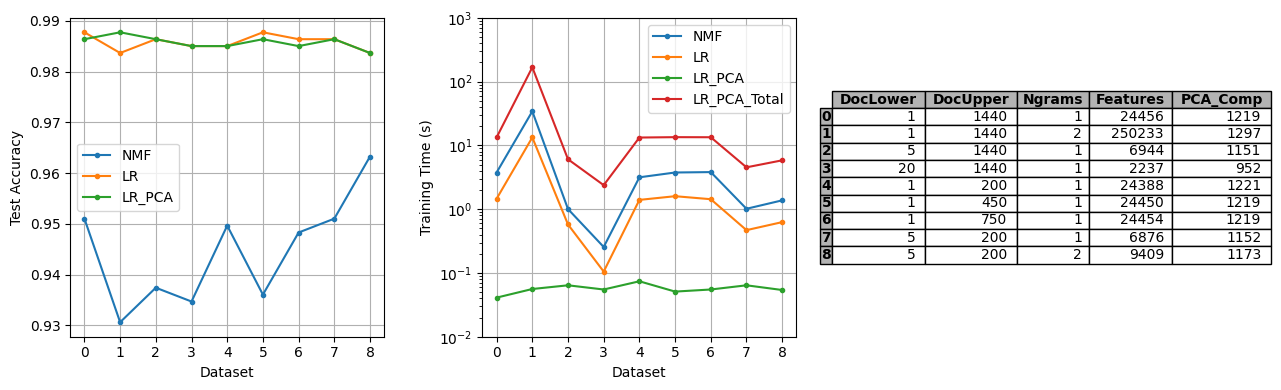

In [30]:
accs = [dataset_df['TestAcc'], model_df['TestAcc'], model_df['PCA_TestAcc']]
acc_labels = ['NMF', "LR", 'LR_PCA']
times = [dataset_df['Time_NMF'], model_df['Time_LR'], model_df['PCA_Time_LR'], model_df['PCA_Time_Total']]
plot_performance(accs, acc_labels, times, acc_labels+['LR_PCA_Total'], dataset_df, tlow=0.01, thigh=1000)

From the charts and table we can make a few observations:

Accuracy:
1. LR and LR_PCA (LR with PCA-transformed data) had very similar accuracies across datasets (98% to 99%), which were significantly higher across all datasets than NMF
2. The highest overall accuracy (98.8%) was tied three-ways between LR and LR_PCA on different datasets
3. While the LR and LR_PCA models each had a training accuracy of 100%, which could indicate over-fitting, they still achieved a high test accuracy

Datasets:
1. Looking at baseline LR, the inclusion of 2-grams caused a decrease in accuracy in each case, which was unexpected per the earlier NMF results
2. Similar to NMF, the performance of LR was affected by the word trimming thresholds, with some evidence that a higher-performing combination of upper and lower limits may exist
3. LR_PCA performed best on the largest base dataset (no word trimming, with 2-grams), which may be a result of providing the most information for PCA to fit upon

Training Time:
1. Using PCA reduced the training time for LR by up to two orders of magnitude, but when the overhead of performing PCA is added the total time is typically an order of magnitude higher than baseline
2. Baseline LR had faster training times across all datasets than NMF 

### Conclusion

In this project unsupervised Non-Negative Matrix Factorization (NMF) and supervised LogisticRegression (LR) models were trained with the goal of predicting categories for the BBC News Classification dataset.

The "Term Frequency, Inverse Document Frequency" (TF-IDF) method was used to convert the text of each article into a sparse numeric vector representation. Nine different variants were generated to evaluate the effects of removing over-used, or under-used words, and including N-grams of length two to evaluate the effect of the additional context. For the supervised models a second set of vectors was prepared based on the Principle Component Analysis (PCA) transforms that would reach 95% of the cumulative explained variance of the original nine variants.

Cross-validated grid search was used to pick roughly optimized parameters for both model types, which were then trained on each variant of the data (only LR was trained on the PCA-transformed variants). LR (with and without PCA transform) was found to be both faster and more accurate than NMF across each dataset, though LR requires labeled data while NMF doesn't. The addition of PCA led to substantial reductions in training time compared to baseline LR (up to two orders of magnitude), but at the cost of additional pre-processing time and with approximately the same accuracy. 

When models were trained on varying quantities of the available training data it was found that the testing accuracy of NMF rapidly increased with data quantity, then leveled-off, achieving the same accuracy at 20% of the data as 100% of the data. For LR, the testing accuracy continued increasing as additional data was added.

Clearly, both NMF and LR are capable of producing highly accurate predictive models, but have tradeoffs that make them more or less suitable for a given application.

Future work on this topic may include: exploring additional parameter tuning for NMF, the use of ensembles, and other text vectorization/feature extraction methods.

### References
Bijoy Bose. (2019). BBC News Classification. Kaggle. https://kaggle.com/competitions/learn-ai-bbc

TFIDFTRANSFORMER. scikit. (n.d.). https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer 

Kachkach, A. (2018, January 10). Problem-solving with ML: Automatic Document Classification | Google Cloud Blog. Google. https://cloud.google.com/blog/products/ai-machine-learning/problem-solving-with-ml-automatic-document-classification 